In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.ops import box_convert
from source_code.card_detector import CardDetector
from source_code.dataloader_utils import MTGCardsDataset, get_transform_pipe
from source_code.config import *
import torchvision.transforms.functional as fn
from torchvision.io import read_image, ImageReadMode
from torchvision.utils import draw_bounding_boxes
import numpy as np

In [15]:
# SOURCE_PATH = CONFIG["training"]["DEST_PATH"]
SOURCE_PATH = "models/present_run_local_weight_5_10x10"

In [17]:
# Load the unaltered (not normalized) version of the image
test_image = read_image("./data/aug_test_22k/159116_1.png", mode=ImageReadMode.RGB)
# test_image = fn.resize(img=test_image, size=(640, 640))
index = 20
position = [399.0,256.0,136,238]

In [18]:
anchor_boxes = torch.Tensor([[198.27963804, 206.74086672],
       [129.59395666, 161.90171490],
       [161.65437828, 232.34624509]
]) # Anchor boxes acquired from k-means clustering of the dataset

In [19]:
model = CardDetector(
  img_dims= (CONFIG["dataset"]["img_w"], CONFIG["dataset"]["img_h"]),
  anchor_boxes=anchor_boxes,
  num_anchors_per_cell=CONFIG["dataset"]["num_anchors_per_cell"],
)
if SOURCE_PATH is not None:
    model.load_state_dict(torch.load(SOURCE_PATH))

feature_map_dims = (model.features_w, model.features_h)

transform_pipe = get_transform_pipe(img_w=CONFIG["dataset"]["img_w"], img_h=CONFIG["dataset"]["img_h"])

test_dataset = MTGCardsDataset(
  annotations_file=CONFIG["dataset"]["annotations_file_test"],
  img_dir=CONFIG["dataset"]["img_dir"], #TODO: change directory when we have the actual data
  anchor_boxes=model.anchor_boxes,
  feature_map_dims=feature_map_dims,
  img_dims= (CONFIG["dataset"]["img_w"], CONFIG["dataset"]["img_h"]),
  num_anchors_per_cell=CONFIG["dataset"]["num_anchors_per_cell"],
  num_max_boxes=CONFIG["dataset"]["num_max_boxes"],
  transform=transform_pipe,
  limit=None
)
test_dataloader = DataLoader(test_dataset, batch_size=CONFIG["dataloader"]["batch_size"]) 

In [20]:
images, labels = next(iter(test_dataloader))

print(labels[index][torch.where(labels[index][:,:,:,0] == 1)])
print(torch.where(labels[index][:,:,:,0] == 1))

print(labels[index][torch.where(labels[index][:,:,:,0] == 0.8)])
print(torch.where(labels[index][:,:,:,0] == 0.8))

c:\Users\vikio\anaconda3\envs\nsiete_pytorch_project\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([[ 1.0000,  0.4688,  0.0000, -0.1728,  0.0240]])
(tensor([12]), tensor([8]), tensor([2]))
tensor([[ 0.8000,  0.4688,  4.0000, -0.1728,  0.0240]])
(tensor([12]), tensor([4]), tensor([2]))


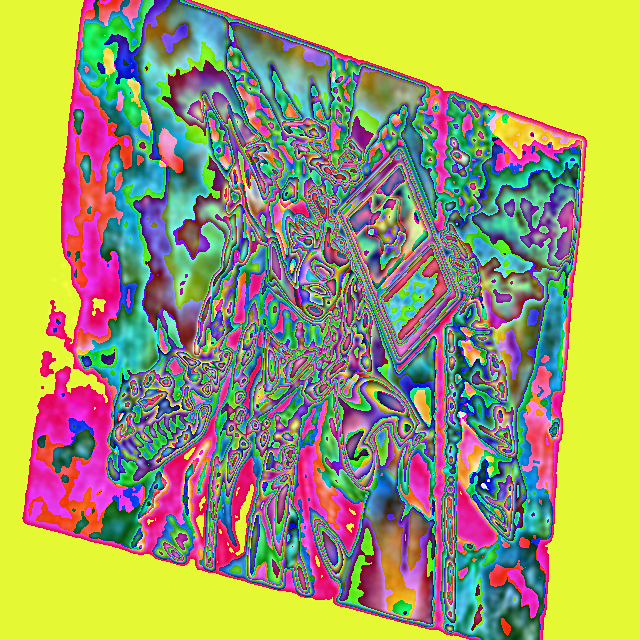

In [22]:
image = images[index]
fn.to_pil_image(image)

PREDICTIONS: 
kept_objectness_scores: tensor([0.7834, 0.4150, 0.1442, 0.1384, 0.1266])
kept_boxes: tensor([[126.1452, 250.4864, 274.8811, 488.1306],
        [275.3101, 169.6818, 440.0568, 405.6032],
        [  0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000]])
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
GROUND_TRUTH: 
kept_objectness_scores: tensor([1., 0., 0., 0., 0.])
kept_boxes: tensor([[331., 137., 467., 375.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.]])
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
pred: tensor([[126.1452, 250.4864, 274.8811, 488.1306],
        [275.3101, 169.6818, 440.0568, 405.6032]])
true: tensor([[331., 137., 467., 375.]])
tensor([0.7834, 0.4150])


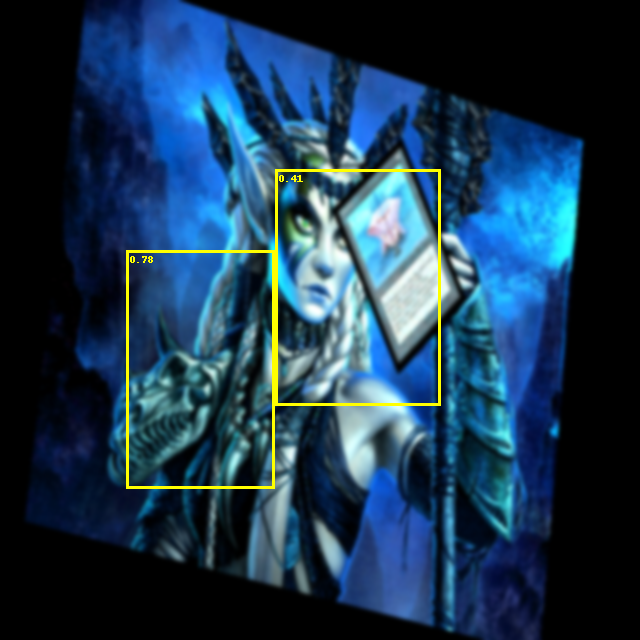

In [27]:
# Predict the bounding box and get the true box
model = model.to(device=model.device)

print("PREDICTIONS: ")
objectness, pred_boxes = model.predict(image, keep_box_score_treshhold=0.35, num_max_boxes=5)
pred_box = pred_boxes.squeeze(0)

print("GROUND_TRUTH: ")
_, true_boxes = model.predict(image, ground_truth=labels[index].unsqueeze(0))
true_box = true_boxes.squeeze(0)

print("pred:", pred_box)
print("true:",true_box)

print(objectness)

box_labels = [f'{score:.2f}' for idx, score in enumerate(objectness)]

bbox_img_tensor = draw_bounding_boxes(image=test_image, boxes=pred_box, labels=box_labels, width=3, colors=(255,255,0))
fn.to_pil_image(bbox_img_tensor)

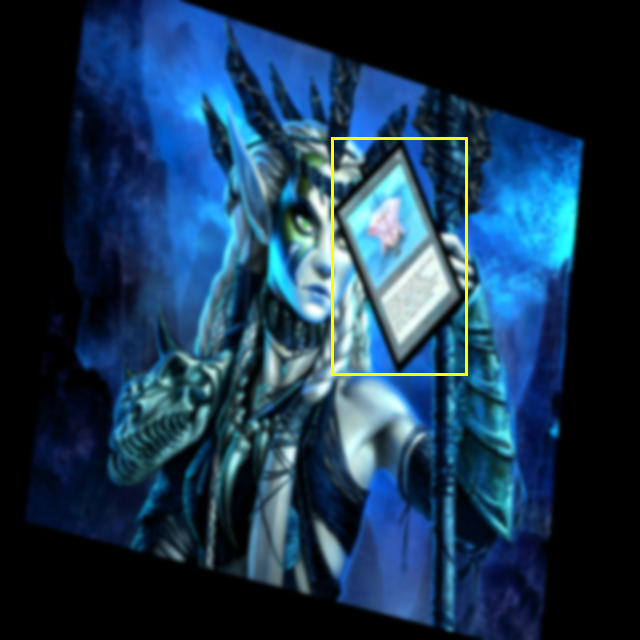

In [24]:
bbox_img_tensor = draw_bounding_boxes(image=test_image, boxes=true_box, width=3, colors=(255,255,0))
fn.to_pil_image(bbox_img_tensor)